<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - SVM
    <br>
<font color=black size=4>
    Alireza Gargoori Motlagh, Alireza Heidari
    
<br><br>
<font size=4>
   **Name**: Arya Jalali<br>
   **Student ID**: 98105665<br> <br>
In this homework, we are going to implement the algorithms from the second and third chapters of the course, so reading the notebooks of these chapters would be quite useful. Also, we are going to evaulate and compare our models by the metrics defined in chapter 3. Keep in mind to complete all of the following questions and write your own codes in the TODO parts.

## <font face="Times New Roman" size=4><div dir=ltr>
## Problem 3: Face Classification by SVM on Eigenfaces (150 points)
In the following problem, we are going to build a classifier to distinguish the faces of 40 people on a toy dataset. The dataset includes 400 pictures of 40 people faces, each by a 64*64 pixel picture. Use the following cell to download the dataset:

In [234]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)
print(faces.images[0].shape)

(400, 4096)
(64, 64)


<font face="Times New Roman" size=4><div dir=ltr>
### Visualization of the Faces (5 points)
Plot an image of each class in one figure using subplots. (Note that the design matrix X is availabe in <code>faces.data</code> and the target values available in <code>faces.target</code> .)

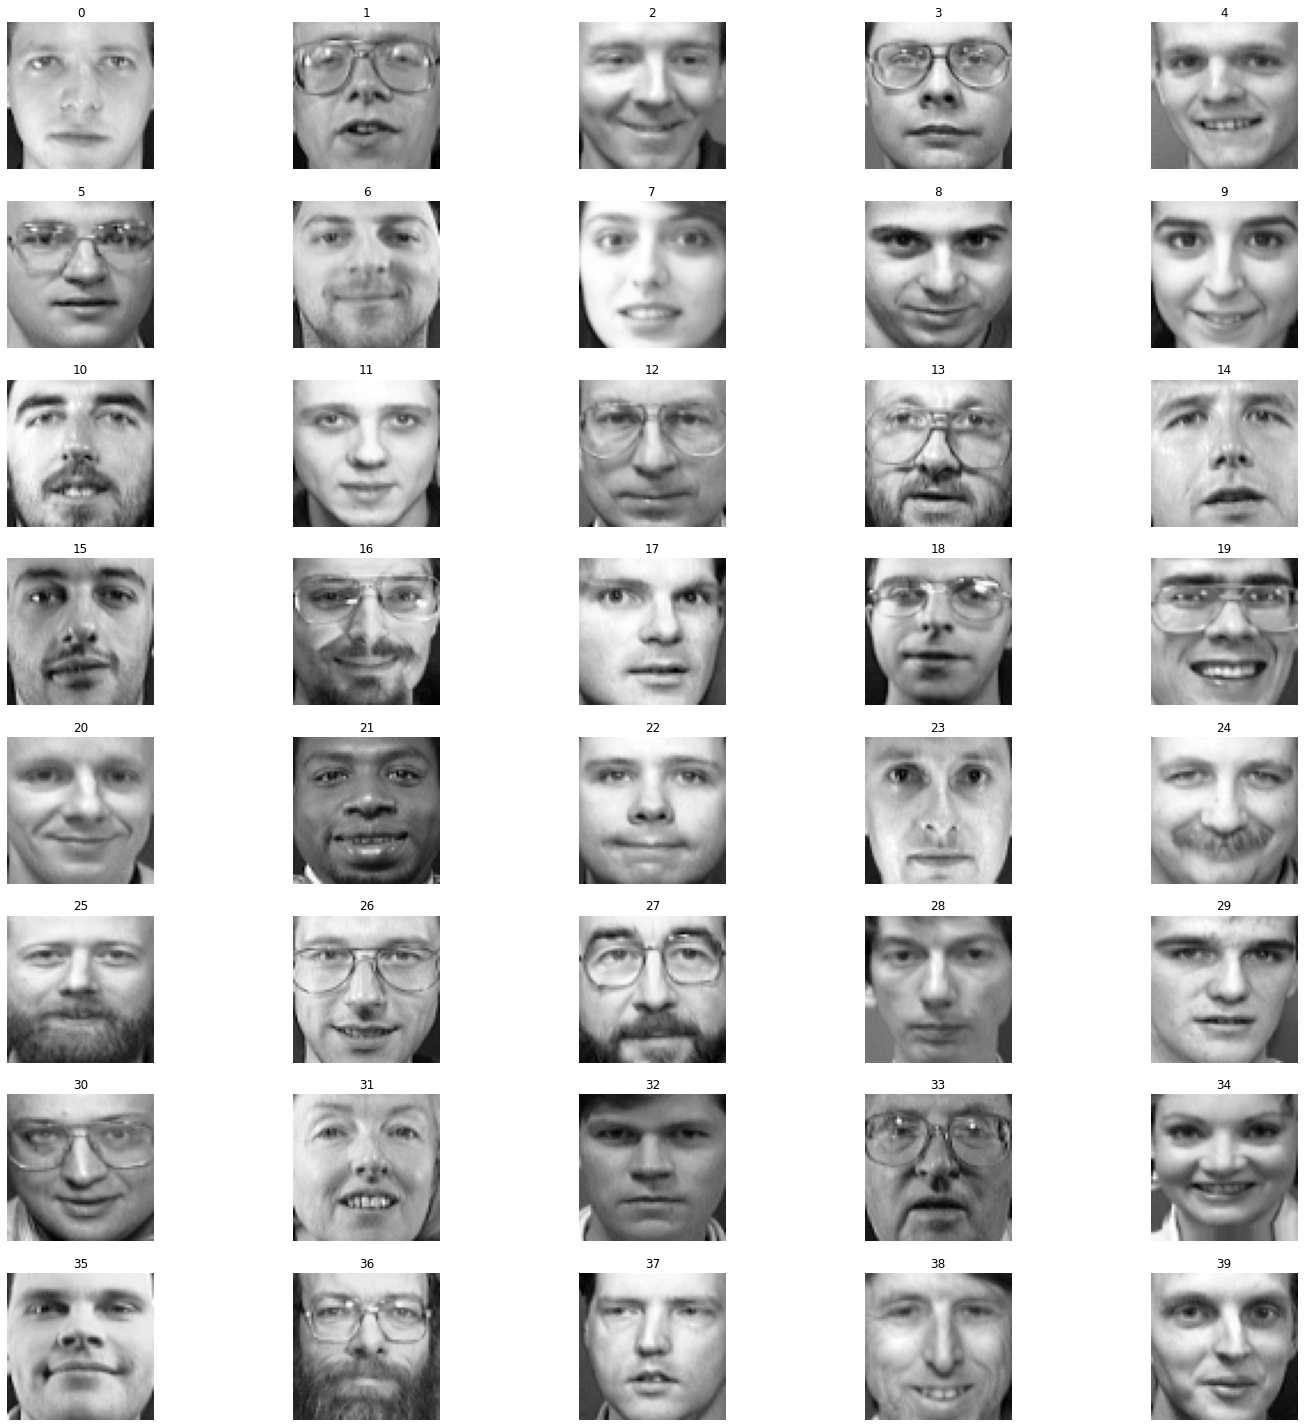

In [235]:
_,indices = np.unique(faces.target,return_index = True)
imgs, titles = faces.data[indices], faces.target[indices]

fig, axs = plt.subplots(8, 5, figsize=(20,20))
fig.tight_layout()
axs = axs.flatten()
for img, ax, title in zip(imgs,axs,titles):
    ax.imshow(img.reshape(64,64),cmap='gray')
    ax.axis("off")
    ax.set_title(title)

<font face="Times New Roman" size=4><div dir=ltr>
### Train-Test Split (2 points)
Split the data into train and test sets and print the dimensions of each set. (70% for train and 30% for test)

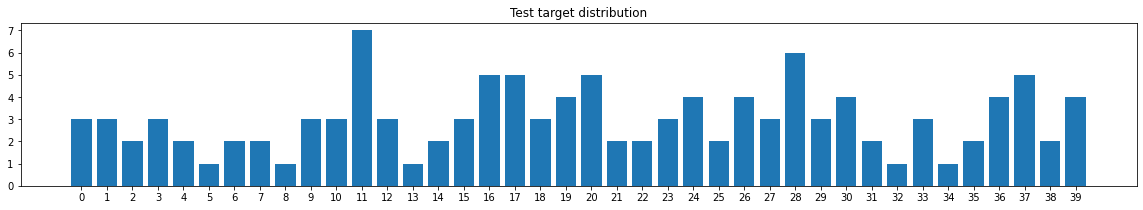

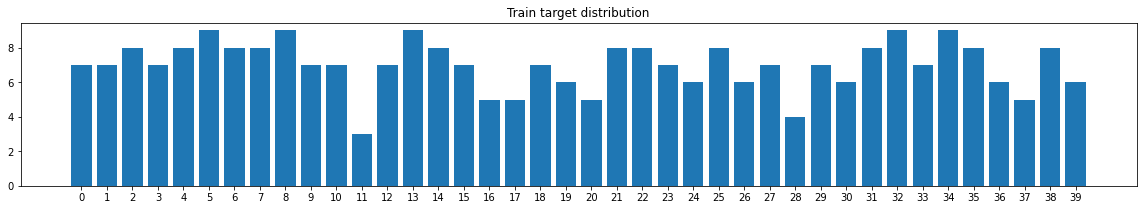

In [236]:
from sklearn.model_selection import train_test_split
X = faces.data
y = faces.target
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.30, random_state = 25)

plt.figure(figsize=(20, 3))
labels, counts = np.unique(y_test, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Test target distribution")
plt.show()

plt.figure(figsize=(20, 3))
plt.title("Train target distribution")
labels, counts = np.unique(y_train, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

## The training set is slightly imbalanced.This can result in an overfit for classes with higher number of images, and an underfit for classes with less than few pictures. Data imbalance can be countered by using class weights, but we didn't implement it in this notebook.

<font face="Times New Roman" size=4><div dir=ltr>
### Dimensionality Reduction (18 points)
As you might have guessed, the number of featuers, i.e. pixels, is quite large and training a classifier might take a considerbale time. However, using a wise method to reduce the dimension of our data could decrease the cost of training the model. In the following cell use PCA (Principal Component Analysis) to reduce the dimension of the dataset. Choose an appropirate number of components in your PCA and explain your reason for your choice.

In [237]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps

pca = PCA(0.80)
pca.fit(X_train)
data_pca = pca.transform(X_train)
data_pca.shape

(280, 24)

## Keeping 24 principal components reduces the number of our features from 4096 to 24, and still keeps 80 percent of the variance of our original data.

<font face="Times New Roman" size=4><div dir=ltr>
Plot the scree plot of the proportion of the variance explained(PVE) vs principal components to determine the number of principal components for futher analysis.

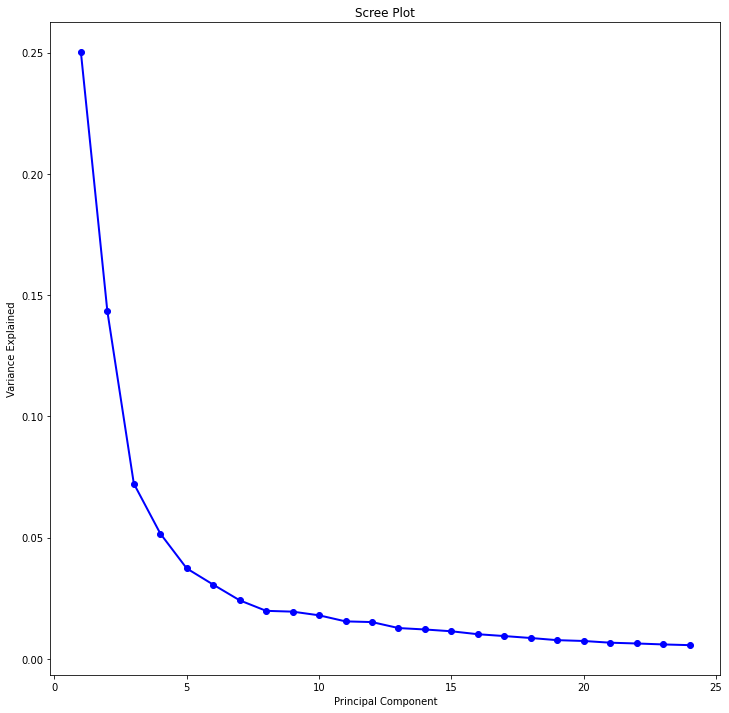

Number of pricipal components kept: 24


In [238]:
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(12, 12))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print('Number of pricipal components kept:',pca.n_components_)

<font face="Times New Roman" size=4><div dir=ltr>
### Eigenfaces: Principal Components Visualization (25 points)
Plot the mean face using your PCA model with <code>pca.mean_</code> attribute followed by a reshape to original dimensions. What is this mean vector?

## The principal components measure deviations about this mean along orthogonal axes.

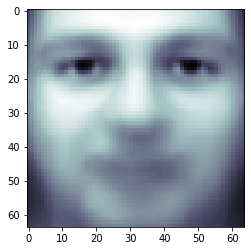

In [239]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

<font face="Times New Roman" size=4><div dir=ltr>
Eigenfaces is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. Plot the 30 first eigenfaces sorted by their rank from the most important to the lowest. Can you explain what these faces indicate?

24


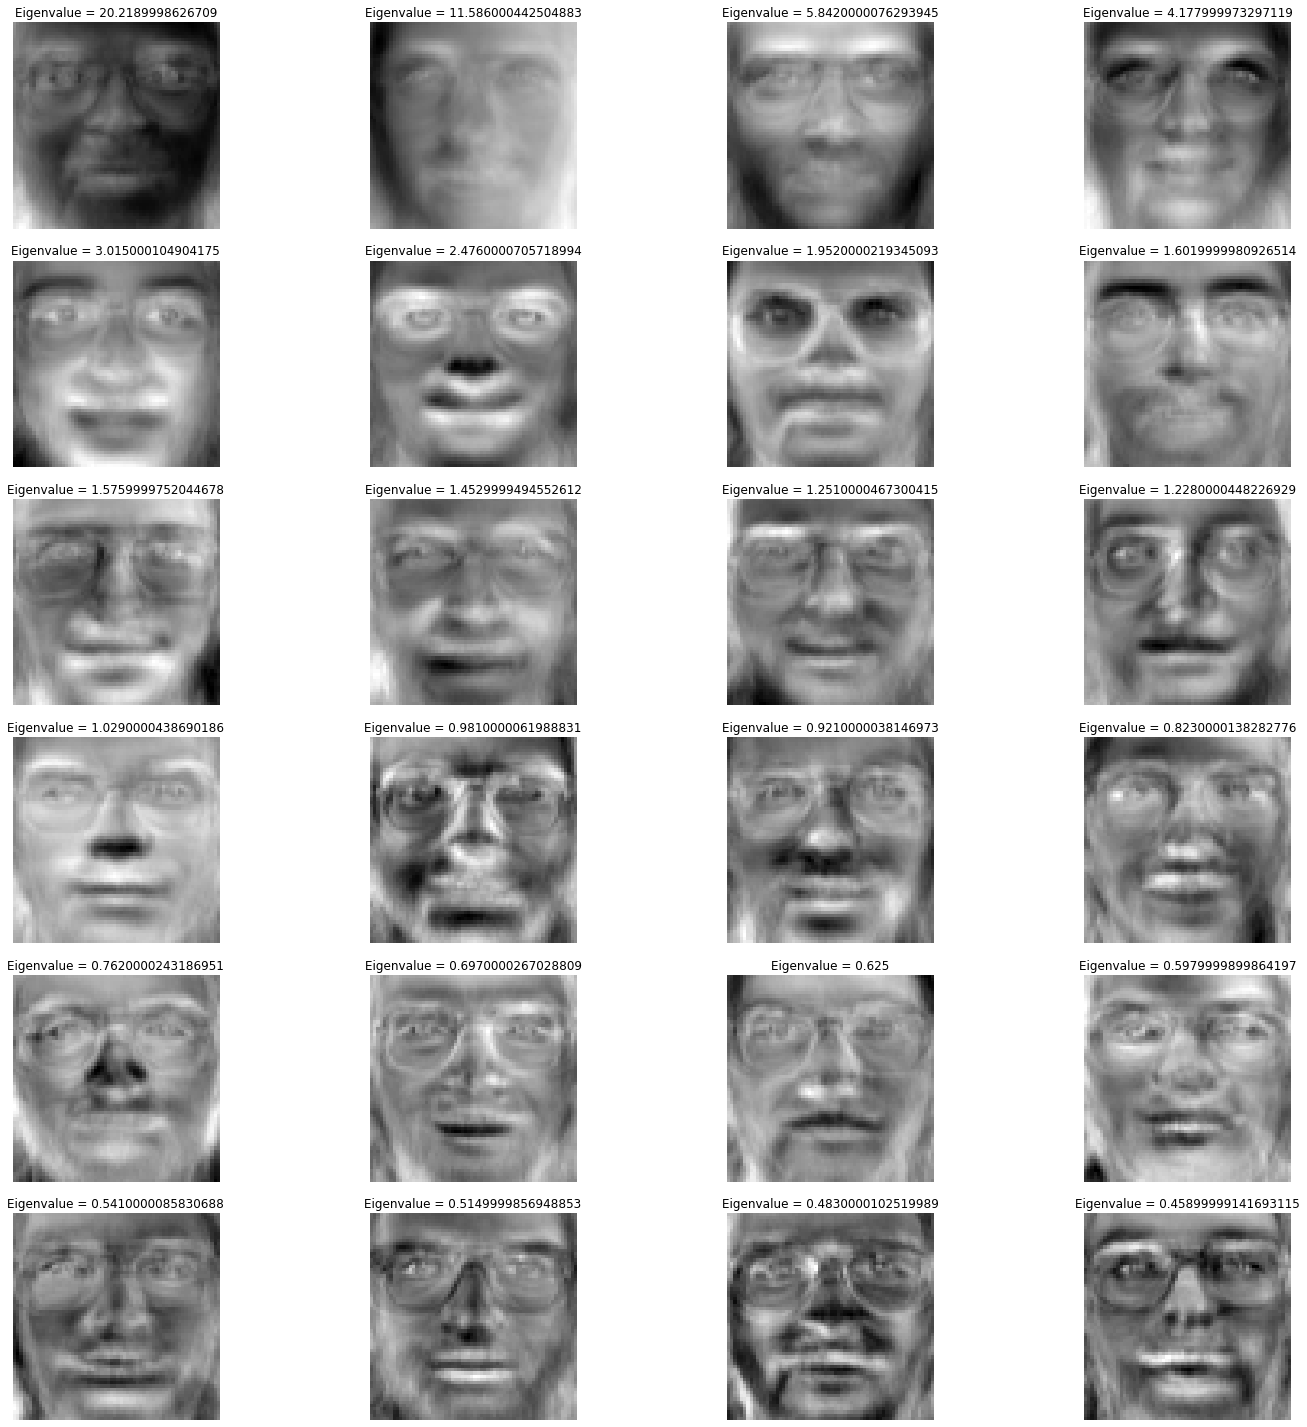

In [240]:
imgs,titles = pca.components_, pca.explained_variance_
fig, axs = plt.subplots(6,4, figsize=(20,20))
fig.tight_layout()
print(len(imgs))
axs = axs.flatten()
for img, ax, title in zip(imgs,axs,titles):
    ax.imshow(img.reshape(64,64),cmap='gray')
    ax.axis("off")
    title = f'Eigenvalue = {title.round(3)}'
    ax.set_title(title)

## The components (“eigenfaces”) are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

## The whiter a part is, the more important that part is to our principal component. In other words, whiter pixels are larger than their black counterparts, and when we project our images onto these principal components, the black pixels cancel that part of our picture.

<font face="Times New Roman" size=4><div dir=ltr>
Transform your train and test sets to the new feature space using your PCA module. 

In [241]:
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test_new = pca.transform(X_test)

<font face="Times New Roman" size=4><div dir=ltr>
### Training your SVM Classifier (50 points)
Train an SVM classifier on the transformed dataset in the new feature space. You should use Grid Search Cross Validation or other validation techniques to obtain the best hyperparameters for your classifier. 

In [242]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


param_grid = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3]
}
  
grid = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy')
  
# fitting the model for grid search
grid.fit(X_train, y_train)

print("Best paramaters for svm classifier:", grid.best_params_)
print("Best accuracy score acheived:", grid.best_score_)

clf = grid.best_estimator_
print("Test accuracy:",clf.score(X_test_new, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


Best paramaters for svm classifier: {'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy score acheived: 0.925
Test accuracy: 0.9416666666666667


<font face="Times New Roman" size=4><div dir=ltr>
After training your model, we can check its prediction on test samples. Run the following cell to check your model predictions with the target values on test samples. Predictions with red label indicate false classification of your model.

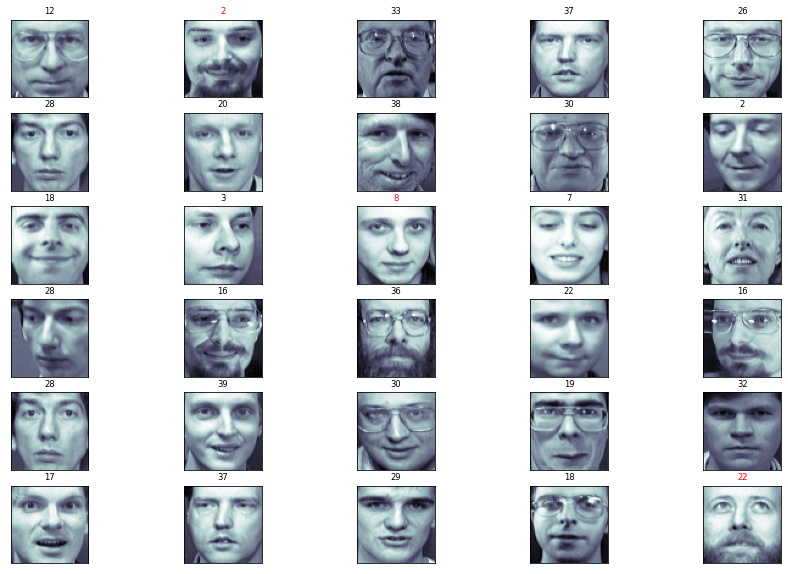

In [243]:
fig = plt.figure(figsize=(15, 10))
for i in range(30):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_new[i, np.newaxis])[0] #X_test_new is the transformed X_test after PCA.
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

<font face="Times New Roman" size=4><div dir=ltr>
## Performance Measures
Let's evaluate your classifier to find out how good your model is.
    
    
### Precision Recall Tradeoff (20 points)
Plot the precision and recall versus the decision threshold figure and precision vs recall figure.

Text(0, 0.5, 'Precision')

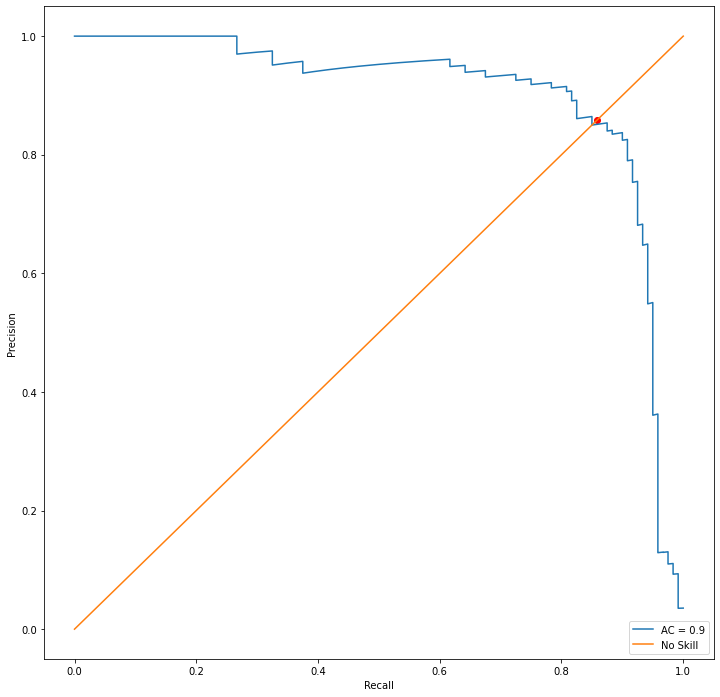

In [244]:
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier


clf = OneVsRestClassifier(clf)
clf.fit(X_train,y_train)

precision,recall,average_precision,threshold = dict(),dict(),dict(),dict()

y_test_binary = label_binarize(y_test, classes = np.unique(y_train))
y_score = clf.decision_function(X_test_new)

precision["micro"], recall["micro"], threshold["micro"] = precision_recall_curve(
    y_test_binary.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_binary, y_score, average="micro")

f = recall["micro"]
g = precision["micro"]
h = threshold["micro"]

idx = np.argwhere(np.diff(np.sign(f - g))).flatten().min()


plt.figure(figsize=(12, 12))
plt.plot(f[idx], f[idx], 'ro')
plt.plot(f,g, label = f'AC = {average_precision["micro"].round(2)}')
plt.plot(f,f,'-',label = 'No Skill')
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

Threshold at the intersection point = -0.18556390608499518
Recall at intersection point = 0.85


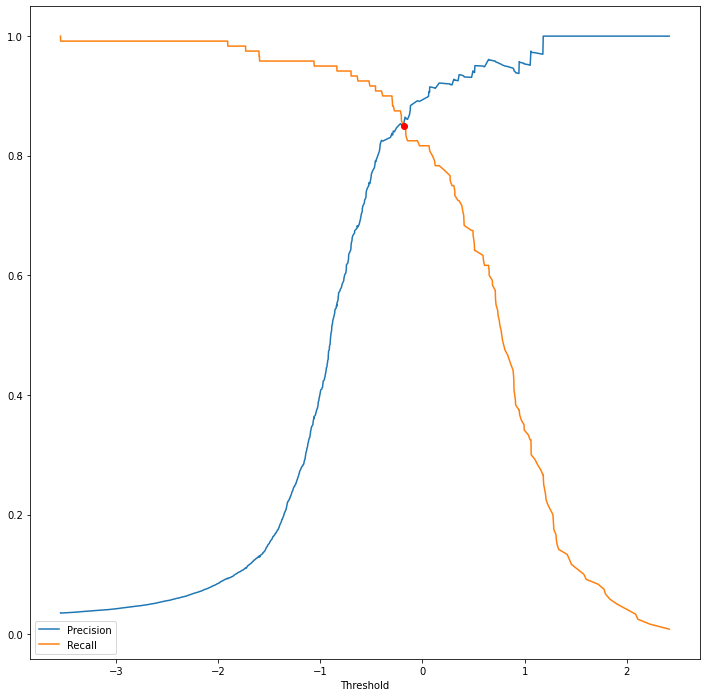

In [245]:
import matplotlib.patches as mpatches

idx = np.argwhere(np.diff(np.sign(f - g))).flatten().max()

plt.figure(figsize=(12, 12))
plt.plot(h,g[:-1], label = 'Precision')
plt.plot(h,f[:-1], label = 'Recall')
plt.plot(h[idx], g[idx], 'ro', zorder=10)
plt.xlabel("Threshold")
plt.legend()
print(f'Threshold at the intersection point = {h[idx]}')
print(f'Recall at intersection point = {f[idx]}')

<font face="Times New Roman" size=4><div dir=ltr>
Then find the decision threshold, where the recall is equal to the precision. Write down it in the below cell:
    <br>
note: it should be apparent in the above figures.

decision_threshold $\approx$ -0.19

recall at the above threshold $\approx$ 0.85

<font face="Times New Roman" size=4><div dir=ltr>
### ROC/AUC (10 points)
Train a RandomForestClassifier with 30 estimators then plot a ROC curve, and calculate AUC for both randomForsetClassifier and your SVM classifier that you trained earlier, which one is the best by considering AUC indicator?


In [246]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(30)
RFC.fit(X_train, y_train)

preds = RFC.predict(X_test_new)

print(sum(preds == y_test) / len(y_test))

0.85


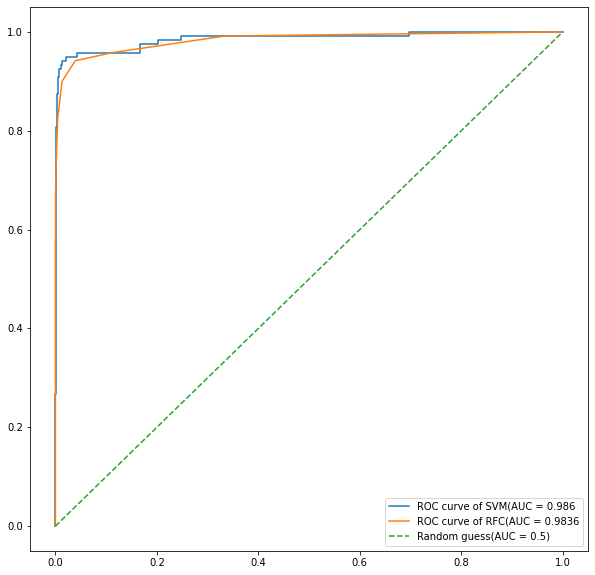

In [247]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score_forest = RFC.predict_proba(X_test_new)

fig = plt.figure(figsize = (10,10))
FP, TP , Thresholds = roc_curve(y_test_binary.ravel(), y_score.ravel())
FP_R,TP_R,Thresholds_R = roc_curve(y_test_binary.ravel(), y_score_forest.ravel())

ROC_AUC_R = auc(FP_R,TP_R)
ROC_AUC = auc(FP,TP)

plt.plot(FP,TP,label =f'ROC curve of SVM(AUC = {ROC_AUC.round(4)}')
plt.plot(FP_R,TP_R,label = f"ROC curve of RFC(AUC = {ROC_AUC_R.round(4)}")
plt.plot(FP,FP,'--'	,label = "Random guess(AUC = 0.5)")
plt.legend(loc ="lower right")

## The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

## Comparing the 2 classifiers we can infer from the plot that SVM has performed better than RFC ever so slightly.

<font face="Times New Roman" size=4><div dir=ltr>
### Classification Report (5 points)
Use the <code>classification_report</code> to describe the performance of your SVM model with different metrics. Explain your results and compare the predictions of model on different classes in few sentences.

In [248]:
from sklearn.metrics import classification_report
labels, counts = np.unique(y_test, return_counts=True)
labels = list(map(str, labels.tolist()))
print(classification_report(y_test.tolist(), clf.predict(X_test_new).tolist()
, target_names=labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         2
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      0.57      0.73         7
          12       0.67      0.67      0.67         3
          13       1.00      1.00      1.00         1
          14       0.50      1.00      0.67         2
          15       1.00      1.00      1.00         3
          16       1.00      0.60      0.75         5
          17       1.00    

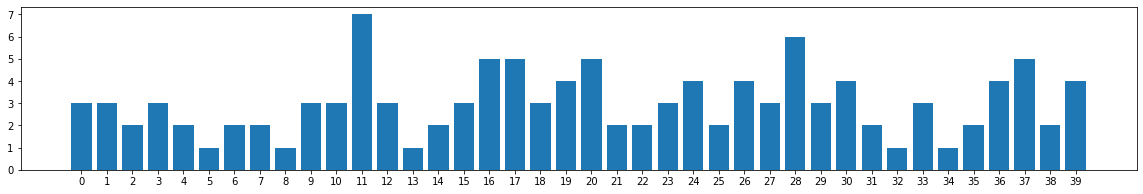

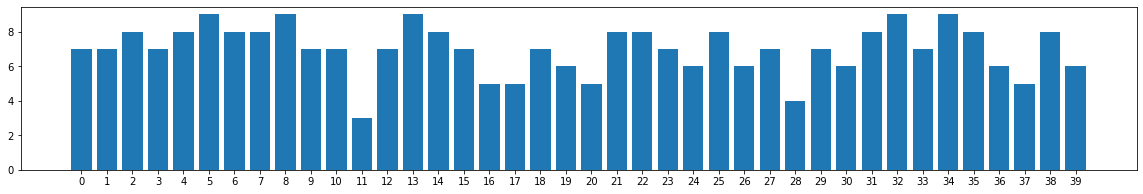

In [249]:
from sklearn.model_selection import train_test_split
X = faces.data
y = faces.target
_,_,y_train_u,y_test_u = train_test_split(X, y, test_size=0.30, random_state = 25)

plt.figure(figsize=(20, 3))
labels, counts_u = np.unique(y_test_u, return_counts=True)
plt.bar(labels, counts_u, align='center')
plt.gca().set_xticks(labels)
plt.show()

plt.figure(figsize=(20, 3))
labels, counts_u = np.unique(y_train_u, return_counts=True)
plt.bar(labels, counts_u, align='center')
plt.gca().set_xticks(labels)
plt.show()

## Comparing the count of each of our classes with our models accuracy for that specific class, we can infer that classes with higher number of instances in our training set are easier for our classifier to correctly classify, but classes with less than satisfactory number of instances suffer from underfitting.

<font face="Times New Roman" size=4><div dir=ltr>
### Confusion Matrix (15 points)
Plot the confusion matrix of the classifier's predictions.
Let’s focus on the errors of the plot. Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors, then plot the result.

In [250]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, clf.predict(X_test_new))
print(sum(y_test == clf.predict(X_test_new)) / len(y_test))

0.8916666666666667


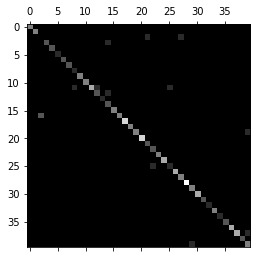

In [251]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

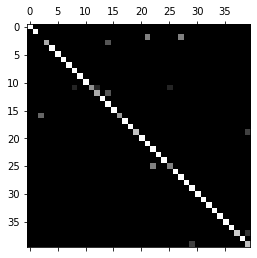

In [252]:
conf_mx_norm = conf_mx / np.matrix(counts).T
plt.matshow(conf_mx_norm, cmap=plt.cm.gray)
plt.show()